In [13]:
from sklearn import decomposition
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import random

In [14]:
# Loading data into numpy arrays
inp_paras = np.load('data/inp_paras_995.npy')
aoas_opt = np.load('data/aoas_opt_995.npy')
airfoils_opt = np.load('data/airfoils_opt_995.npy')

airfoils_opt_new = airfoils_opt.reshape(airfoils_opt.shape[0], -1)
aoas_opt=aoas_opt.reshape(995,-1)
new_paras = np.concatenate((inp_paras,aoas_opt),axis=1)
print(new_paras.shape)
print(aoas_opt.shape)
print(airfoils_opt_new.shape)

(995, 4)
(995, 1)
(995, 384)


In [ ]:
# Standarizing Input Parameters
scaler = StandardScaler()
new_paras_std = scaler.fit_transform(new_paras)

# Initializing K-Fold Cross Validation
k = 6
kf = KFold(n_splits=k, shuffle=True,random_state=42)

In [38]:
# DNN Building
# RelU(Linear) --> ReLU(Linear) --> Linear --> Ouput
# 2 Hidden Layers with ReLU activations

class Airfoil_NN(nn.Module):
    def __init__(self, output_param, input_param=4, neurons_per_layer=[3, 3]):
        super().__init__()
        self.hidden1 = nn.Linear(input_param, neurons_per_layer[0])
        self.act1 = nn.Tanh()
        self.hidden2 = nn.Linear(neurons_per_layer[0], neurons_per_layer[1])
        self.act2 = nn.ReLU()
        self.output = nn.Linear(neurons_per_layer[1], output_param)

    def forward(self, x):
        x = self.act1(self.hidden1(x))
        x = self.act2(self.hidden2(x))
        
        x = self.output(x)
        return x

fold_train_loss = []
fold_test_loss = []

# k-Fold Cross-Validation
for fold, (train_idx, test_idx) in enumerate(kf.split(new_paras_std)):

    fold_train = []
    fold_test = []

    print(f"Fold {fold + 1}/{k}")

    # Split data
    x_train, x_test = new_paras_std[train_idx], new_paras_std[test_idx]
    y_train, y_test = airfoils_opt_new[train_idx],airfoils_opt_new[test_idx]

    # Apply PCA
    pca = PCA(n_components=10)
    y_train_pca = pca.fit_transform(y_train)
    y_test_pca = pca.transform(y_test)

    # Convert to tensors
    x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_pca, dtype=torch.float32)
    x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test_pca, dtype=torch.float32)

    # Model
    model = Airfoil_NN(output_param=10, input_param=4,
                       neurons_per_layer=[32, 64])

    # Loss & Optimizer
    loss_fn = nn.HuberLoss(reduction='mean', delta=0.001) # Less senstive to outlier than MSE
    optimizer = optim.Adam(model.parameters(), lr=0.01,eps=1e-6,weight_decay=1e-6)

    n_epochs = 120
    batch_size = 72

    # Training Loop
    for epoch in range(n_epochs):
        model.train()
        for i in range(0, len(x_train_tensor), batch_size):
            Xbatch = x_train_tensor[i:i+batch_size]
            ybatch = y_train_tensor[i:i+batch_size]

            #print(Xbatch.shape)
            y_pred = model(Xbatch)
            loss = loss_fn(y_pred, ybatch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Performance Monitoring every 20 epochs
        if (epoch % 20 == 0):
            model.eval()
            with torch.no_grad():
                test_pred = model(x_test_tensor)
                test_loss = loss_fn(test_pred, y_test_tensor).item()
                print(
                    f"Epoch {epoch}: Train Loss = {loss.item():.10f}, Testing Loss = {test_loss:.10f}")
                fold_train.append(loss.item())
                fold_test.append(test_loss)


    # After training this fold
    model.eval()
    with torch.no_grad():
        y_test_pred = model(x_test_tensor).numpy()

        # 192 points, (x, y) coordinates
        reconstructed_airfoils = pca.inverse_transform(y_test_pred)
        reconstructed_airfoils = reconstructed_airfoils.reshape(-1, 192, 2)

    fold_train_loss.append(fold_train)
    fold_test_loss.append(fold_test)

Fold 1/6
Epoch 0: Train Loss = 0.0000480564, Testing Loss = 0.0000422337
Epoch 20: Train Loss = 0.0000207838, Testing Loss = 0.0000170495
Epoch 40: Train Loss = 0.0000195318, Testing Loss = 0.0000156082
Epoch 60: Train Loss = 0.0000193650, Testing Loss = 0.0000154795
Epoch 80: Train Loss = 0.0000187028, Testing Loss = 0.0000151382
Epoch 100: Train Loss = 0.0000187521, Testing Loss = 0.0000147322
Fold 2/6
Epoch 0: Train Loss = 0.0000469460, Testing Loss = 0.0000409265
Epoch 20: Train Loss = 0.0000193756, Testing Loss = 0.0000155663
Epoch 40: Train Loss = 0.0000186940, Testing Loss = 0.0000153340
Epoch 60: Train Loss = 0.0000185473, Testing Loss = 0.0000144654
Epoch 80: Train Loss = 0.0000184541, Testing Loss = 0.0000147528
Epoch 100: Train Loss = 0.0000181313, Testing Loss = 0.0000144452
Fold 3/6
Epoch 0: Train Loss = 0.0000493516, Testing Loss = 0.0000347523
Epoch 20: Train Loss = 0.0000215022, Testing Loss = 0.0000143618
Epoch 40: Train Loss = 0.0000207621, Testing Loss = 0.0000141496

In [39]:
print(f"Validation Set Airfoil IDs in last fold: {test_idx.tolist()}")

Validation Set Airfoil IDs in last fold: [1, 13, 14, 20, 21, 27, 32, 34, 40, 47, 52, 58, 62, 64, 71, 80, 87, 91, 98, 99, 102, 105, 106, 121, 128, 130, 134, 138, 156, 160, 161, 166, 187, 189, 191, 200, 201, 205, 214, 216, 230, 241, 243, 251, 252, 269, 270, 273, 276, 288, 295, 308, 313, 315, 330, 337, 339, 343, 345, 366, 372, 378, 379, 385, 387, 389, 391, 401, 406, 413, 418, 427, 435, 454, 455, 458, 459, 461, 466, 471, 474, 475, 476, 484, 489, 491, 492, 498, 502, 504, 508, 510, 520, 546, 555, 560, 561, 562, 564, 565, 566, 573, 592, 600, 612, 614, 642, 646, 647, 661, 663, 674, 681, 683, 686, 699, 700, 701, 702, 719, 724, 725, 726, 727, 729, 738, 747, 748, 763, 768, 769, 771, 772, 775, 776, 779, 782, 791, 804, 805, 812, 815, 818, 821, 831, 838, 839, 840, 856, 860, 862, 871, 875, 878, 892, 897, 932, 945, 955, 957, 971, 975, 977, 987, 991]


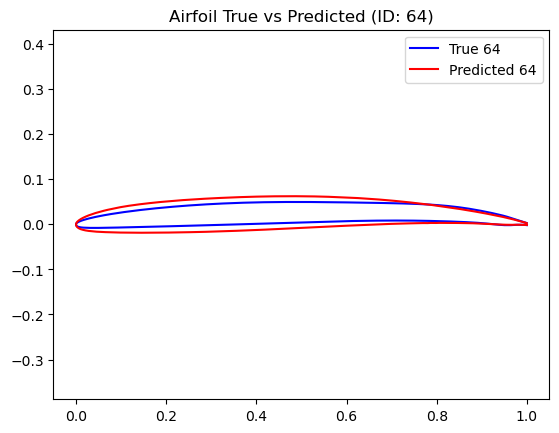

In [40]:
# Pick airfoil ID you want to plot
airfoil_id = 64

# Check if it's in the test set
if airfoil_id in test_idx:
    test_set_index = np.where(test_idx == airfoil_id)[0][0]  # index in test set

    # Plot true vs predicted
    plt.plot(airfoils_opt[airfoil_id, :, 0], airfoils_opt[airfoil_id,
             :, 1], label=f"True {airfoil_id}", color='blue')
    plt.plot(reconstructed_airfoils[test_set_index, :, 0], reconstructed_airfoils[test_set_index, :, 1],
             label=f"Predicted {airfoil_id}", color='red')

    plt.axis('equal')
    plt.legend()
    plt.title(f"Airfoil True vs Predicted (ID: {airfoil_id})")
    plt.show()

else:
    print(
        f" Airfoil ID {airfoil_id} not found in validation set. Pick one from {test_idx.tolist()}")

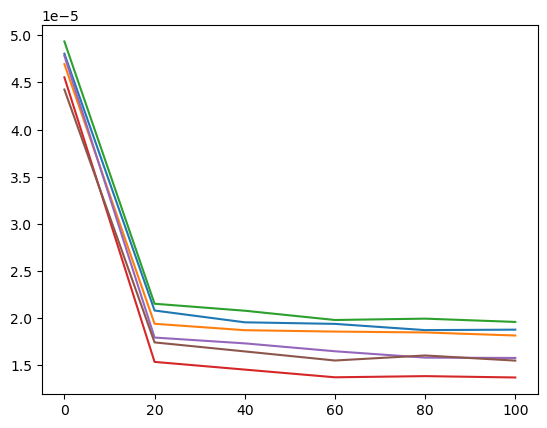

In [41]:
x_vals = [0,20,40,60,80,100]
for i in range(len(fold_train_loss)):
    plt.plot(x_vals, fold_train_loss[i], label=f'Fold {i+1} Train')
    #plt.plot(x_vals, fold_test_loss[i],label=f'Fold {i+1} Test', linestyle='--')

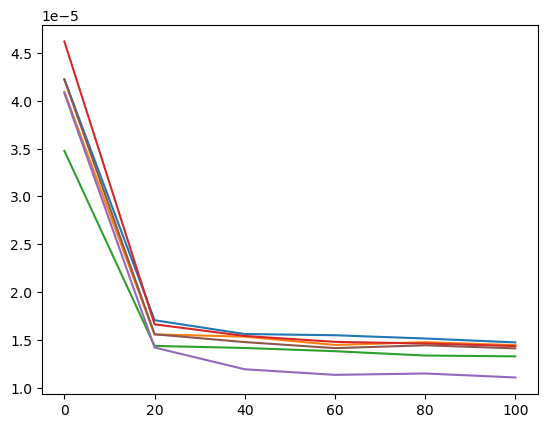

In [42]:
for i in range(len(fold_test_loss)):
    plt.plot(x_vals, fold_test_loss[i], label=f'Fold {i+1} Train')
    # plt.plot(x_vals, fold_test_loss[i],label=f'Fold {i+1} Test', linestyle='--')